# **Generate Knowledge Spaces and Calculate Content Novelty**

In [1]:
import pandas as pd 
df = pd.read_csv('1_df_filtered.csv')
df

,pubid,pubyear,EU_NUTS_ID,itemtitle,abstract,period,subject
0,1908819.0,2000,NL333,Stress concentrations in tubular gap K-joints:...,The present paper offers a comprehensive study...,1,Engineering
1,1908821.0,2000,UKM21,Approximate dynamic analysis of space trusses,This paper presents two new approximate analys...,1,Engineering
2,1908823.0,2000,ITI21,Non-Gaussian along-wind response analysis in t...,With special reference to the role of the non-...,1,Engineering
3,1908824.0,2000,AT130,Dynamic analysis of inelastic primary-secondar...,Two methods are proposed to compute the respon...,1,Engineering
4,1908826.0,2000,UKF22,Theoretical and experimental study on external...,"Using theoretical parametric studies, based on...",1,Engineering
...,...,...,...,...,...,...,...
25102745,46608438.0,2021,FR101,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology
25102746,46608438.0,2021,PT170,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology
25102747,46608438.0,2021,NL423,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology
25102748,46608438.0,2021,NL326,Inflammation of the Sacroiliac Joints and Spin...,Objective To test the impact of inflammation o...,6,Rheumatology


# **TEST: 특정 지역/기간/주제에 대해 먼저 확인**

In [6]:
# group by (region, period, subject) and check number of unique pubid 
check = df.groupby(['EU_NUTS_ID', 'period', 'subject'])['pubid'].nunique().reset_index()
check.columns = ['EU_NUTS_ID', 'period', 'subject', 'pubid_count']
check = check.sort_values(by='pubid_count', ascending=False)
check

,EU_NUTS_ID,period,subject,pubid_count
99873,FR104,4,Physics,10491
99987,FR104,5,Physics,10222
99761,FR104,3,Physics,9447
99659,FR104,2,Physics,9209
99562,FR104,1,Physics,8360
...,...,...,...,...
160549,NL221,4,Thermodynamics,10
191651,SE125,1,Pediatrics,10
55675,DEB35,4,Reproductive Biology,10
139219,ITF46,1,Veterinary Sciences,10


In [8]:
df[
    (df['EU_NUTS_ID'] == 'FR104') &
    (df['period'] == 4) &
    (df['subject'] == 'Physics')
].shape

(10491, 8)

In [ ]:
# ---- SELECT a test group (replace with one that exists in your data) ----
test_key = ('FR104', 4, 'Physics')

# Filter to just this group
df_test = df[
    (df['EU_NUTS_ID'] == test_key[0]) &
    (df['period'] == test_key[1]) &
    (df['subject'] == test_key[2])
].copy()

# Combine title and abstract again for safety
df_test['text'] = df_test['itemtitle'].fillna('') + '. ' + df_test['abstract'].fillna('')

# Function to get SPECTER embedding
def get_specter_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embedding.squeeze().cpu().numpy()

# Generate embeddings
embeddings_test = []
for text in tqdm(df_test['text'], desc="Embedding test group"):
    emb = get_specter_embedding(text)
    embeddings_test.append(emb)

# Store embeddings
df_test['embedding'] = embeddings_test

# Compute centroid
test_vectors = np.stack(df_test['embedding'].to_numpy())
test_centroid = np.mean(test_vectors, axis=0)

# Output
print("\n✅ Embedding and centroid calculation complete.")
print("Number of documents in group:", len(df_test))
print("Centroid shape:", test_centroid.shape) # 768-dimensional vector
print("Sample of centroid values:", test_centroid[:10]) # the first 10 values of the 768-dimensional centroid vector

Embedding test group: 100%|██████████| 10491/10491 [01:48<00:00, 96.46it/s] 


✅ Embedding and centroid calculation complete.
Number of documents in group: 10491
Centroid shape: (768,)
Sample of centroid values: [-0.55275625 -0.14582151  0.3350964   0.2794113   0.09753134  0.51239383
  0.48133704  0.6015365   0.26702192  0.36128253]


**Check the test data outcome**

In [13]:
# Find representative documents that are closest to the centroid
from sklearn.metrics.pairwise import cosine_similarity
sims = cosine_similarity(np.stack(df_test['embedding'].to_numpy()), test_centroid.reshape(1, -1)).flatten()
df_test['sim_to_centroid'] = sims

# print(df_test[['itemtitle', 'sim_to_centroid']].sort_values(by='sim_to_centroid', ascending=False).head(5))

# Sort and show full text with similarity
top_representative = df_test[['itemtitle', 'text', 'sim_to_centroid']].sort_values(by='sim_to_centroid', ascending=False).head(5)

# Display full text (not truncated)
for i, row in top_representative.iterrows():
    print(f"\n📘 Title: {row['itemtitle']}")
    print(f"🔢 Similarity to centroid: {row['sim_to_centroid']:.4f}")
    print(f"📝 Full text:\n{row['text']}")
    print("="*100)


📘 Title: Effective Field Theory for Lattice Nuclei
🔢 Similarity to centroid: 0.8997
📝 Full text:
Effective Field Theory for Lattice Nuclei. We show how nuclear effective field theory (EFT) and ab initio nuclear-structure methods can turn input from lattice quantum chromodynamics (LQCD) into predictions for the properties of nuclei. We argue that pionless EFT is the appropriate theory to describe the light nuclei obtained in LQCD simulations carried out at pion masses heavier than the physical pion mass. We solve the EFT using the effective-interaction hyperspherical harmonics and auxiliary-field diffusion Monte Carlo methods. Fitting the three leading-order EFT parameters to the deuteron, dineutron, and triton LQCD energies at m(pi) approximate to 800 MeV, we reproduce the corresponding alpha-particle binding and predict the binding energies of mass-5 and mass-6 ground states.</p>

📘 Title: In-medium effects for nuclear matter in the Fermi-energy domain
🔢 Similarity to centroid: 0.897

In [ ]:
# Find atypical (low similarity) documents 
# print(df_test[['itemtitle', 'sim_to_centroid']].sort_values(by='sim_to_centroid').head(5))

# Sort by similarity to centroid (ascending = least similar)
least_representative = df_test[['itemtitle', 'text', 'sim_to_centroid']].sort_values(by='sim_to_centroid').head(5)

# Display full text
for i, row in least_representative.iterrows():
    print(f"\n📘 Title: {row['itemtitle']}")
    print(f"🔢 Similarity to centroid: {row['sim_to_centroid']:.4f}")
    print(f"📝 Full text:\n{row['text']}")
    print("="*100)



📘 Title: Ultrahigh Density Memristor Neural Crossbar for On-Chip Supervised Learning
🔢 Similarity to centroid: 0.5847
📝 Full text:
Ultrahigh Density Memristor Neural Crossbar for On-Chip Supervised Learning. Although there are many candidates for future computing systems, memristor-based neural crossbar (NC) is considered especially promising, thanks to their low power consumption, high density, and fault tolerance. However, their implementation is still hindered by the limitations of CMOS neuron and learning cells. In this paper, we present a memristor-based NC that implements on-chip supervised learning. Instead of using a standard CMOS neuron, a simple CMOS inverter realizes the activation function. More importantly, we propose a compact learning cell that consists of a crossbar latch of two antiparallel oriented binary memristors. This design allows for higher density integration and could be naturally extended to a multilayer neural network. Using the CMOS 40-nm design kit and a 

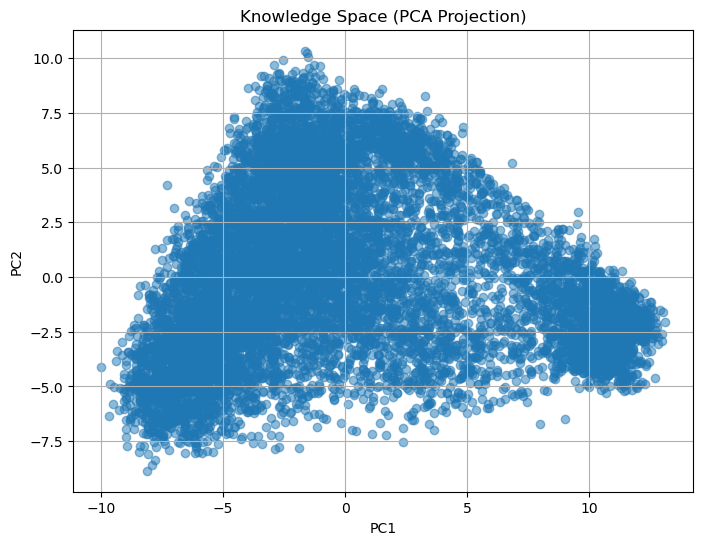

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Convert to matrix
X = np.stack(df_test['embedding'].to_numpy())

# Apply PCA
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], alpha=0.5)
plt.title("Knowledge Space (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [16]:
from sklearn.metrics.pairwise import cosine_distances

# Define novelty function specific to test set
def compute_novelty_from_test_centroid(embedding):
    return cosine_distances([embedding], [test_centroid])[0][0]

# Apply to df_test
df_test['content_novelty'] = df_test['embedding'].apply(compute_novelty_from_test_centroid)
df_test

,pubid,pubyear,EU_NUTS_ID,itemtitle,abstract,period,subject,text,embedding,sim_to_centroid,content_novelty
2572908,7273465.0,2012,FR104,Bose-Einstein condensation and thermalization ...,"In ultra-relativistic heavy ion collisions, th...",4,Physics,Bose-Einstein condensation and thermalization ...,"[-0.9035919, -0.55202645, 0.89607483, 0.794960...",0.857166,0.142834
2601610,7422206.0,2012,FR104,Multiprobe Signatures of the Valence Crossover...,"In the heavy fermion compound CeCu2Si2, superc...",4,Physics,Multiprobe Signatures of the Valence Crossover...,"[-0.72060543, -1.0211439, 0.6097518, -0.029345...",0.839801,0.160199
2604947,7444780.0,2012,FR104,Nanosized Mesoporous Manganese Oxides: Synthes...,Nanoscale manganese oxides with mesopores at c...,4,Physics,Nanosized Mesoporous Manganese Oxides: Synthes...,"[-0.70784014, 0.14072973, 0.5943451, -0.162015...",0.718921,0.281079
2608155,7461738.0,2012,FR104,Advances in carbon nanotube-noble metal cataly...,This review article is dealing with heterogene...,4,Physics,Advances in carbon nanotube-noble metal cataly...,"[-1.06691, -0.32662395, 0.682675, -0.026422882...",0.692266,0.307734
2614666,7485194.0,2012,FR104,Search for (B)over-bar -> Lambda(c)+ Xl(-) (nu...,We present a search for semileptonic B decays ...,4,Physics,Search for (B)over-bar -> Lambda(c)+ Xl(-) (nu...,"[-1.1796274, 0.0656224, -0.7052742, 0.97864556...",0.782850,0.217150
...,...,...,...,...,...,...,...,...,...,...,...
18397042,35607946.0,2012,FR104,Search for a heavy top-quark partner in final ...,The results of a search for direct pair produc...,4,Physics,Search for a heavy top-quark partner in final ...,"[-0.70232713, -0.1618063, 0.27162895, 0.305047...",0.753067,0.246933
19019218,36706082.0,2015,FR104,Pyrochemical reprocessing of molten salt fast ...,The nuclear fuel reprocessing is a prerequisit...,4,Physics,Pyrochemical reprocessing of molten salt fast ...,"[-0.5868127, -0.9091562, 0.930696, 0.72299385,...",0.673723,0.326277
19395001,37356118.0,2013,FR104,Windowless thin solid-hydrogen target: CHyMENE,We report on the production of a windowless pu...,4,Physics,Windowless thin solid-hydrogen target: CHyMENE...,"[-0.015375519, -1.0910565, -0.059858687, 0.909...",0.768972,0.231028
23603773,44268831.0,2015,FR104,Search for new phenomena in final states with ...,Results of a search for new phenomena in final...,4,Physics,Search for new phenomena in final states with ...,"[-0.91422665, 0.53237224, -0.28283074, 1.0229,...",0.789401,0.210599


In [ ]:
# Inspect most novel documents

# Sort by novelty (descending = most novel)
# df_test.sort_values('content_novelty', ascending=False)[['itemtitle', 'content_novelty']].head(5)

top_novel = df_test.sort_values('content_novelty', ascending=False).head(5)
for i, row in top_novel.iterrows():
    print(f"\n📘 Title: {row['itemtitle']}")
    print(f"📏 Content novelty (cosine distance): {row['content_novelty']:.4f}")
    print(f"📝 Full text:\n{row['text']}")
    print("="*100)


📘 Title: Ultrahigh Density Memristor Neural Crossbar for On-Chip Supervised Learning
📏 Content novelty (cosine distance): 0.4153
📝 Full text:
Ultrahigh Density Memristor Neural Crossbar for On-Chip Supervised Learning. Although there are many candidates for future computing systems, memristor-based neural crossbar (NC) is considered especially promising, thanks to their low power consumption, high density, and fault tolerance. However, their implementation is still hindered by the limitations of CMOS neuron and learning cells. In this paper, we present a memristor-based NC that implements on-chip supervised learning. Instead of using a standard CMOS neuron, a simple CMOS inverter realizes the activation function. More importantly, we propose a compact learning cell that consists of a crossbar latch of two antiparallel oriented binary memristors. This design allows for higher density integration and could be naturally extended to a multilayer neural network. Using the CMOS 40-nm design

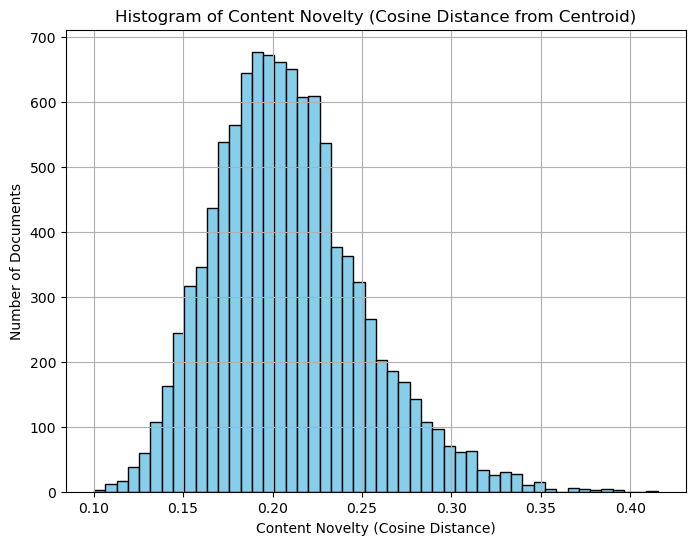

In [19]:
import matplotlib.pyplot as plt

# Drop any NaNs just in case
novelty_scores = df_test['content_novelty'].dropna()

plt.figure(figsize=(8, 6))
plt.hist(novelty_scores, bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Content Novelty (Cosine Distance from Centroid)")
plt.xlabel("Content Novelty (Cosine Distance)")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()

# **Main Analysis**
- Apply the code below to the entire dataset (1_df_filtered.csv)

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.preprocessing import normalize

# Load SPECTER model
tokenizer = AutoTokenizer.from_pretrained("allenai/specter")
model = AutoModel.from_pretrained("allenai/specter")
model.eval()

# GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Combine title + abstract into one string
df['text'] = df['itemtitle'].fillna('') + '. ' + df['abstract'].fillna('')

# Function to get embeddings using SPECTER
def get_specter_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    return embedding.squeeze().cpu().numpy()

# Create column to store embeddings
embeddings = []

# Loop with tqdm
for text in tqdm(df['text'], desc="Embedding documents"):
    emb = get_specter_embedding(text)
    embeddings.append(emb)

# Store embeddings as numpy array
df['embedding'] = embeddings

# --- Group by Region, Period, Subject to form Knowledge Spaces ---
# create a dict like: {(region, period, subject): [list of vectors]}

from collections import defaultdict
import numpy as np

knowledge_spaces = defaultdict(list)

for _, row in df.iterrows():
    key = (row['EU_NUTS_ID'], row['period'], row['subject'])
    knowledge_spaces[key].append(row['embedding'])

# Compute centroids for each group
centroids = {k: np.mean(vectors, axis=0) for k, vectors in knowledge_spaces.items()}

In [ ]:
knowledge_spaces.to_csv('2_knowledge_spaces.csv', index=False)

# Key: tuple → (EU_NUTS_ID, period, subject)
# Value: list of NumPy arrays → embeddings of all papers in that region/period/field group

In [ ]:
centroids.to_csv('2_centroids.csv', index=False)

# This has the same keys as knowledge_spaces, but the values are single mean vectors (centroids):

**Compute content novelty as the cosine distance between each paper's embedding and the centroid of its region-period-subject group (i.e., knowledge space centroid)**

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

# Define function to compute cosine distance from centroid
def compute_novelty(row):
    key = (row['EU_NUTS_ID'], row['period'], row['subject'])
    centroid = centroids.get(key)
    if centroid is None:
        return np.nan
    return cosine_distances([row['embedding']], [centroid])[0][0]

# Apply function to each row
df['content_novelty'] = df.apply(compute_novelty, axis=1)

In [ ]:
# Check a sample of novelty values
df[['EU_NUTS_ID', 'period', 'subject', 'content_novelty']].head()

# Distribution of novelty
df['content_novelty'].hist(bins=50)